# Project: Detection of medical masks

## 1. Problem Statment

Facial recognition is a key area in computer vision and pattern recognition. Significant research in the past has contributed to the development of sophisticated facial recognition algorithms. With the development of convolutional networks, highly accurate image classification has become possible.

Beyond image labeling, there are often tasks where a specific object in the image is important. For example, due to the recent COVID-19 outbreak, wearing surgical masks has become mandatory for everyone outside their home, which in turn has led to the need to develop an approach for detecting masks on people's faces.

Imagine your company has the opportunity to help the world by training a model to detect whether people are wearing masks. You want to compare the two types of detectors studied (single-layer and two-layer) and present a short report to your management. To justify your choice of model to your colleagues, you decided to use the Intersection over Union and Average Precision metrics.

## 2. Import Libraries and Define Constants

In [1]:

import os
os.environ['NO_ALBUMENTATIONS_UPDATE'] = '1'
# os.environ["COMET_DISABLE_AUTO_LOGGING"] = "1"
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import numpy as np 
import pandas as pd 
import torch
import torchvision
from torchvision import transforms, datasets, models
from torchvision.ops import box_iou
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import glob
import xml.etree.ElementTree as et
import time
from tqdm import tqdm


# Define devices
#device = torch.device("mps") #torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Used device:', device)

# Define paths
images_dir = 'data/rcnn/images/'
annotations_dir = 'data/rcnn/annotations/'

# Torch random seed
random_seed = 42

# Selecting a low batch size due to hardware limitations
batch_size = 4

# background is located on the position 0
classes = [_, 'without_mask','with_mask','mask_weared_incorrect']

Used device: cpu


In [2]:
print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

Torch version: 2.9.1
Torchvision version: 0.24.1


## 3. Loading Data to the DataLoader

In [3]:
class FaceMaskDataset(torch.utils.data.Dataset):


    def __init__(self, images_dir, annotation_dir, width, height, transforms=None):
        self.images_dir = images_dir
        self.annotation_dir = annotation_dir
        self.height = height
        self.width = width
        self.transforms = transforms
        
        # sort image file names
        self.imgs = [image for image in sorted(os.listdir(images_dir))]
        self.annotate = [image for image in sorted(os.listdir(annotation_dir))]
        

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        image_path = os.path.join(self.images_dir, img_name)

        # adjust image color scheme and size
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # normalize image
        img_res /= 255.0
        
        # load the annotation
        annot_filename = self.annotate[idx]
        annot_file_path = os.path.join(self.annotation_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # image width and height
        wt = img.shape[1]
        ht = img.shape[0]
        
        # loading bounding boxes
        for member in root.findall('object'):
            labels.append(classes.index(member.find('name').text))
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            xmin_corr = self.__clamp__(xmin_corr, 0, self.width-1)
            xmax_corr = self.__clamp__(xmax_corr, 0, self.width-1)
            ymin_corr = self.__clamp__(ymin_corr, 0, self.height-1)
            ymax_corr = self.__clamp__(ymax_corr, 0, self.height-1)

            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # converting boxes to torch.Tensor format
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1])*(boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['area'] = area
        target['iscrowd'] = iscrowd

        image_id = torch.tensor([idx])
        target['image_id'] = image_id
            
        if self.transforms:
            sample = {
                'image': img_res,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            target['labels'] = torch.Tensor(sample['labels']).to(torch.int64)
        else:
            target['labels'] = torch.as_tensor(labels, dtype=torch.int64)

        return img_res, target

    def __len__(self):
        return len(self.imgs)
    
    
    def __clamp__(self, num, min_value, max_value):
        return max(min(num, max_value), min_value)


# instantiate dataset
dataset = FaceMaskDataset(images_dir, annotations_dir, 480, 480)
print('Length of dataset:', len(dataset), '\n')

# get a sample from the dataset
img, target = dataset[83]
print('Image shape:', img.shape, '\n', 'Target:', target)

Length of dataset: 853 

Image shape: (480, 480, 3) 
 Target: {'boxes': tensor([[ 57.6000, 153.4694,  86.4000, 189.3878],
        [397.2000, 125.7143, 427.2000, 173.0612]]), 'labels': tensor([2, 3]), 'area': tensor([1034.4490, 1420.4080]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([83])}


Define elper function to visualize bboxes.

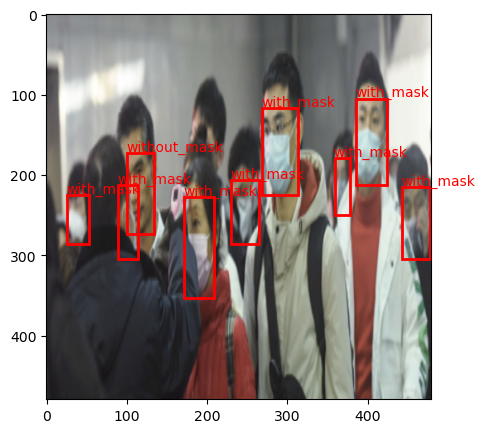

In [4]:
def plot_img_bbox(img, target):
    fig, im = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    im.imshow(img)
    for i, box in enumerate(target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        im.add_patch(rect)
        box_label = classes[int(target['labels'][i])]
        if 'scores' in target.keys():
            box_label += f': {int(target['scores'][i]*100)}%'
        im.text(int(box[0]),int(box[1]-2), box_label, color='red', fontsize=10)

    plt.show()


# visualize the 1st image and its target
img, target = dataset[1]
plot_img_bbox(img, target)

Define transformations to be applied to the images during training to augment data.

In [5]:
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                            A.RandomBrightnessContrast(p=0.2),
                            A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

Define the collate function.

In [6]:
def collate_fn(batch):
    return tuple(zip(*batch))

Split data to train and test and initialize data loaders.

In [7]:
max_items = len(dataset)

dataset = FaceMaskDataset(images_dir, annotations_dir, 480, 480, transforms=get_transform(train=True))
dataset_test = FaceMaskDataset(images_dir, annotations_dir, 480, 480, transforms=get_transform(train=False))

dataset = torch.utils.data.Subset(dataset, range(max_items))
dataset_test = torch.utils.data.Subset(dataset_test, range(max_items))

# split dataset into train and test set
torch.manual_seed(random_seed)
indices = torch.randperm(len(dataset)).tolist()

test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)

/opt/miniconda3/envs/tensorflow_env/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/opt/miniconda3/envs/tensorflow_env/lib/python3.12/site-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


Visualize the first batch of images with bounding boxes.

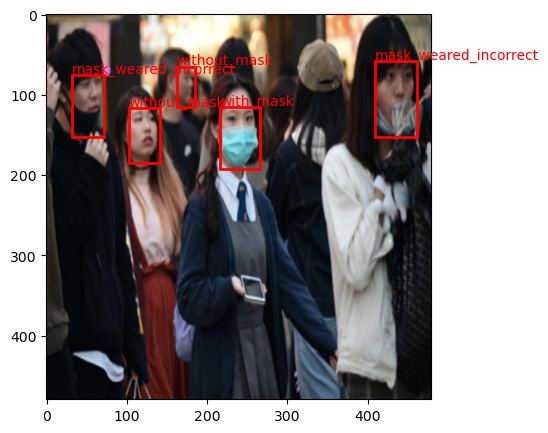

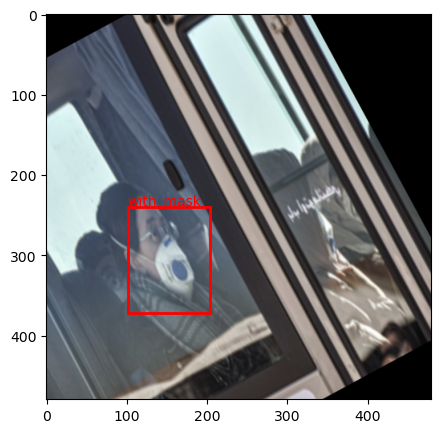

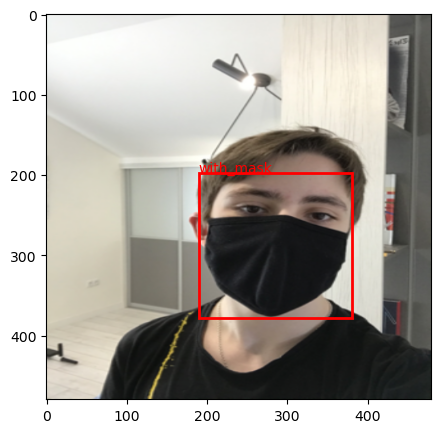

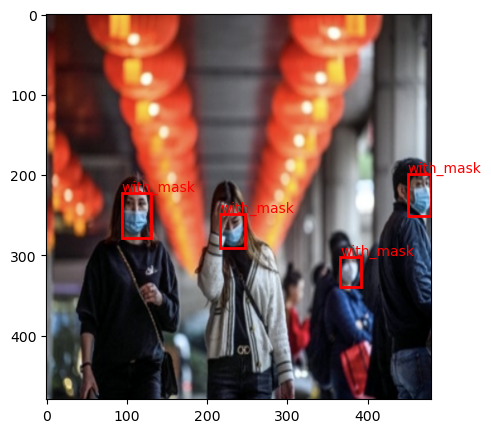

In [8]:
images, targets = next(iter(data_loader))

for i in range(len(images)):
    img = images[i].permute(1, 2, 0).numpy()
    target = targets[i]
    plot_img_bbox(img, target)

## 4. Training the Faster RCNN Model

Update the model's last predicting layer.

In [9]:
def get_model_instance_segmentation(num_classes):
    model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

Train the model.

In [10]:
num_classes = len(classes)
model_rcnn = get_model_instance_segmentation(num_classes)

num_epochs = 20

model_rcnn.to(device)

params = [p for p in model_rcnn.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

start = time.time()

for epoch in range(num_epochs):
    model_rcnn.train()
    epoch_loss = 0
    for imgs, annotations in tqdm(data_loader):
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model_rcnn(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()         
        epoch_loss += losses.item()
    print('Epoch_loss = ',epoch_loss)

end = time.time()
print('Training time (in seconds): ', end - start)

100%|██████████| 171/171 [21:20<00:00,  7.49s/it]


Epoch_loss =  87.21872913092375


100%|██████████| 171/171 [2:28:45<00:00, 52.20s/it]    


Epoch_loss =  61.84958842396736


100%|██████████| 171/171 [21:18<00:00,  7.47s/it]


Epoch_loss =  58.30304169654846


100%|██████████| 171/171 [20:25<00:00,  7.16s/it]


Epoch_loss =  52.88660528883338


100%|██████████| 171/171 [21:24<00:00,  7.51s/it]


Epoch_loss =  51.540634013712406


100%|██████████| 171/171 [19:57<00:00,  7.00s/it]


Epoch_loss =  50.78220783174038


100%|██████████| 171/171 [21:27<00:00,  7.53s/it]


Epoch_loss =  47.67105235159397


100%|██████████| 171/171 [20:30<00:00,  7.20s/it]


Epoch_loss =  47.39076394587755


100%|██████████| 171/171 [20:30<00:00,  7.20s/it]


Epoch_loss =  47.513120010495186


100%|██████████| 171/171 [21:41<00:00,  7.61s/it]


Epoch_loss =  44.81653122603893


100%|██████████| 171/171 [19:40<00:00,  6.90s/it]


Epoch_loss =  43.760059107095


100%|██████████| 171/171 [21:14<00:00,  7.45s/it]


Epoch_loss =  42.79965277761221


100%|██████████| 171/171 [19:47<00:00,  6.94s/it]


Epoch_loss =  41.86073684319854


100%|██████████| 171/171 [20:39<00:00,  7.25s/it]


Epoch_loss =  41.77231805026531


100%|██████████| 171/171 [19:24<00:00,  6.81s/it]


Epoch_loss =  41.21193839982152


100%|██████████| 171/171 [19:27<00:00,  6.83s/it]


Epoch_loss =  40.24165484495461


100%|██████████| 171/171 [20:29<00:00,  7.19s/it]


Epoch_loss =  40.100408267229795


100%|██████████| 171/171 [19:27<00:00,  6.83s/it]


Epoch_loss =  39.32466319203377


100%|██████████| 171/171 [20:28<00:00,  7.18s/it]


Epoch_loss =  37.54683541134


100%|██████████| 171/171 [19:29<00:00,  6.84s/it]

Epoch_loss =  37.686104252934456
Training time (in seconds):  32251.07761669159


Overall training time for 20 epochs: 8.96 hours.

## 5. Validating the Faster RCNN Model and Calculating the Metrics

Calculate Intersection over Union

In [11]:
def evaluate_iou_map(model, dataloader, device):
    model.eval()
    ious = []
    metric = MeanAveragePrecision()

    with torch.no_grad():
        for images, targets in tqdm(dataloader):
            images = [img.to(device) for img in images]
            outputs = model(images)

            outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            metric.update(outputs, targets)

            for output, target in zip(outputs, targets):
                # Get predicted and true boxes
                pred_boxes = output['boxes'].to(device)
                true_boxes = target['boxes'].to(device)

                if len(pred_boxes) == 0 or len(true_boxes) == 0:
                    continue

                # Compute IoU matrix between all pairs
                iou_matrix = box_iou(pred_boxes, true_boxes)

                # Best IoU per predicted box
                best_ious, _ = iou_matrix.max(dim=1)
                ious.extend(best_ious.to(device).tolist())

    mean_iou = sum(ious) / len(ious)
    print(f'Mean IoU: {mean_iou:.4f}')
    
    mAP = metric.compute()
    print(f'Mean Average Precision (mAP): {mAP['map_50']:.4f}')


evaluate_iou_map(model_rcnn, data_loader_test, device)


100%|██████████| 43/43 [02:09<00:00,  3.00s/it]


Mean IoU: 0.2997
Mean Average Precision (mAP): 0.8648


The trained model shows the following metric `mAP_50` value on the validation data set: 0.86. Which is above the required value of 0.85.

Define an auxiliary function which takes the initial forecast and the threshold iou and applies non-maximum suppression to filter out overlapping boxes.

In [12]:
def apply_nms(orig_prediction, iou_thresh=0.3):
    
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

def torch_to_pil(img):
    return transforms.ToPILImage()(img).convert('RGB')

Render some images with the real boxes and labels, with the predicted ones and after applying the non-maximum suppression.

IMAGE 1
predicted #boxes:  5
real #boxes:  5
EXPECTED OUTPUT


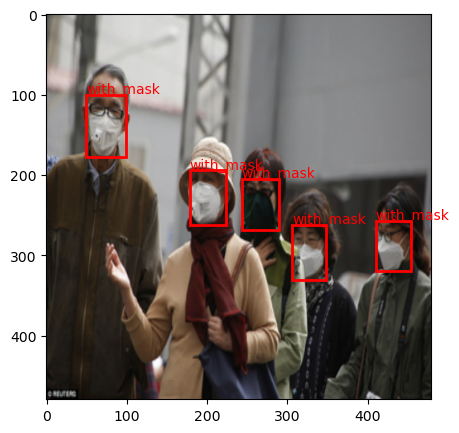

MODEL OUTPUT


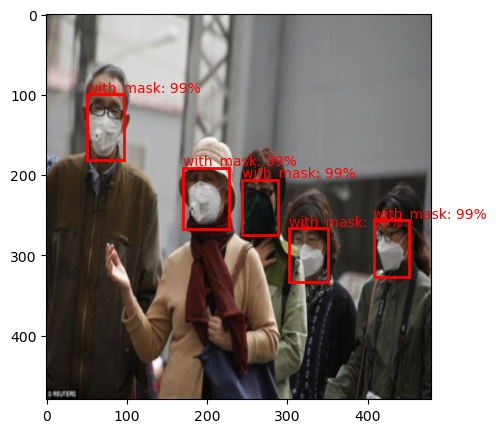

NMS APPLIED MODEL OUTPUT


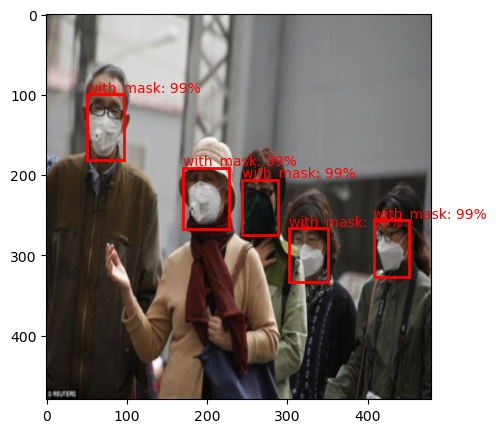

IMAGE 2
predicted #boxes:  8
real #boxes:  1
EXPECTED OUTPUT


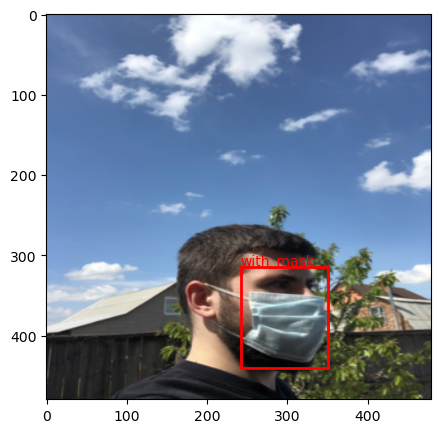

MODEL OUTPUT


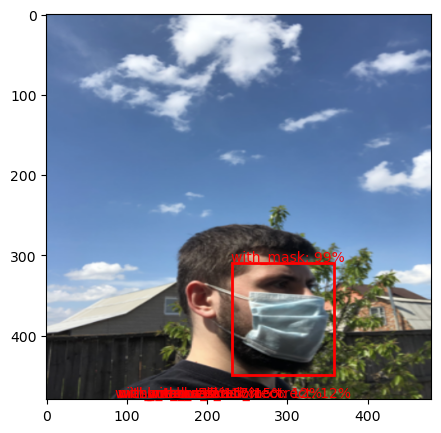

NMS APPLIED MODEL OUTPUT


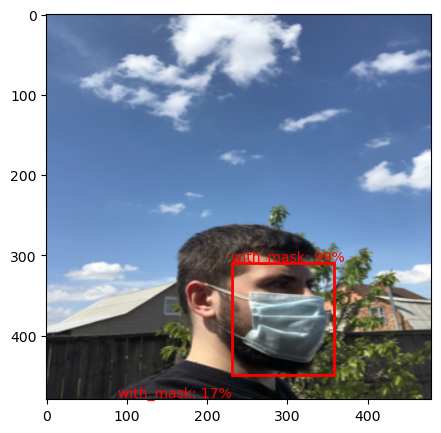

IMAGE 3
predicted #boxes:  7
real #boxes:  3
EXPECTED OUTPUT


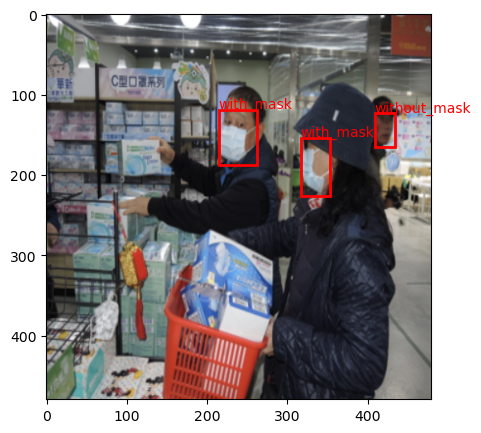

MODEL OUTPUT


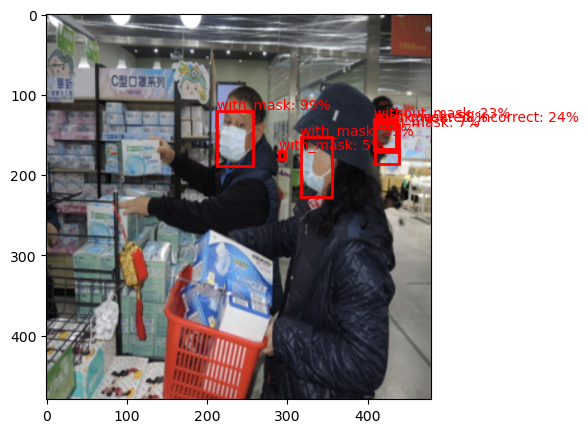

NMS APPLIED MODEL OUTPUT


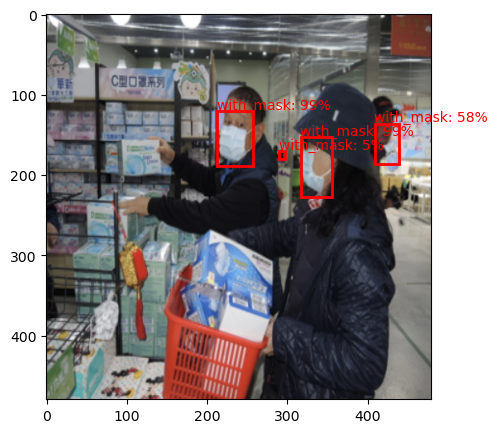

IMAGE 4
predicted #boxes:  10
real #boxes:  4
EXPECTED OUTPUT


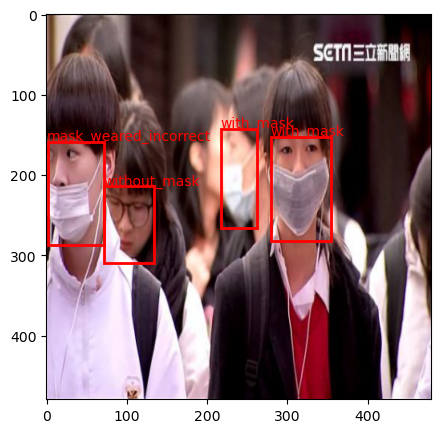

MODEL OUTPUT


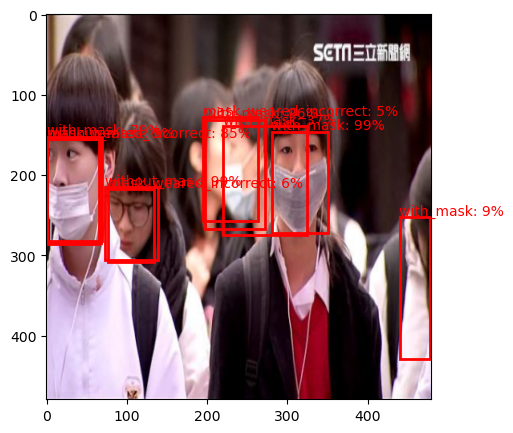

NMS APPLIED MODEL OUTPUT


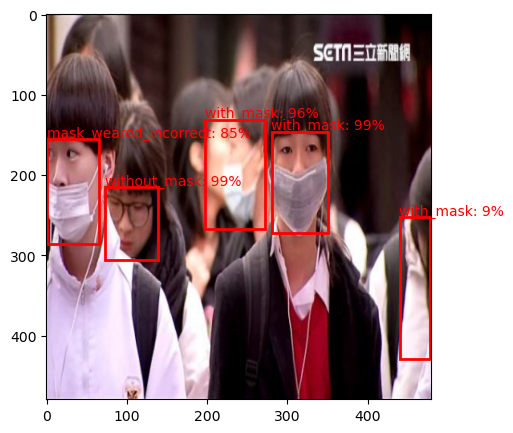

In [13]:
for i in range(4):
    print(f'IMAGE {i+1}')

    img, target = dataset_test[i]

    model_rcnn.eval()
    with torch.no_grad():
        prediction = model_rcnn([img.to(device)])[0]
        
    print('predicted #boxes: ', len(prediction['labels']))
    print('real #boxes: ', len(target['labels']))
    
    print('EXPECTED OUTPUT')
    plot_img_bbox(torch_to_pil(img), target)
    
    print('MODEL OUTPUT')
    plot_img_bbox(torch_to_pil(img), prediction)
    
    print('NMS APPLIED MODEL OUTPUT')
    nms_prediction = apply_nms(prediction, iou_thresh=0.2)
    plot_img_bbox(torch_to_pil(img), nms_prediction)

## 6. Converging the image annotations to the YOLO format

This code runs only if the output path does not exist.

In [14]:
from pathlib import Path
from PIL import Image

input_dir = Path('data/rcnn/annotations')
images_dir = Path('data/rcnn/images')
output_dir = Path('data/yolo/labels_yolo')

if os.path.exists(output_dir) == False:
    print('Creating output directory:', output_dir)
    output_dir.mkdir(exist_ok=True)

    for xml_file in input_dir.glob('*.xml'):
        tree = et.parse(xml_file)
        root = tree.getroot()

        img_file = root.find('filename').text
        img_path = images_dir / img_file
        with Image.open(img_path) as img:
            w, h = img.size

        label_path = output_dir / (Path(img_file).stem + '.txt')

        with open(label_path, 'w') as f:
            for obj in root.findall('object'):
                cls = obj.find('name').text
                cls_id = classes.index(cls) - 1
                bbox = obj.find('bndbox')
                xmin = float(bbox.find('xmin').text)
                ymin = float(bbox.find('ymin').text)
                xmax = float(bbox.find('xmax').text)
                ymax = float(bbox.find('ymax').text)

                # Convert to YOLO normalized format
                x_center = (xmin + xmax) / 2 / w
                y_center = (ymin + ymax) / 2 / h
                width = (xmax - xmin) / w
                height = (ymax - ymin) / h

                f.write(f'{cls_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n')


## 7. Training the YOLO 5m Model

In [15]:
model_yolo = YOLO("yolov5mu.pt")

start = time.time()

# Train
metrics = model_yolo.train(
    data="data.yaml",   # dataset config
    epochs=num_epochs,
    imgsz=480,
    batch=4
)

end = time.time()
print('Training time (in seconds): ', end - start)

New https://pypi.org/project/ultralytics/8.3.233 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.231 🚀 Python-3.12.8 torch-2.9.1 CPU (Apple M2 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=480, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov5mu.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train11, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, 

COMET ERROR: Failed to create Comet experiment, reason: ValueError('Comet.ml requires an API key. Please provide as the first argument to Experiment(api_key) or as an environment variable named COMET_API_KEY ')


WARNING ⚠️ Comet installed but not initialized correctly, not logging this run. Comet.ml requires an API key. Please provide as the first argument to Experiment(api_key) or as an environment variable named COMET_API_KEY 
Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      5280  ultralytics.nn.modules.conv.Conv             [3, 48, 6, 2, 2]              
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2     65280  ultralytics.nn.modules.block.C3              [96, 96, 2]                   
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    444672  ultralytics.nn.modules.block.C3              [192, 192, 4]                 
  5                  -1  1    664320  ultralytics.nn.mod

The trained model shows the following metric `mAP_50` value on the validation data set: 0.85. Which is matching the minimum required value.

Overall training time for 20 epochs: 1.3 hours.

Visualizing results:

EXPECTED OUTPUT 1
![EXPECTED OUTPUT](val_batch0_labels.jpg)

MODEL OUTPUT 1
![EXPECTED OUTPUT](val_batch0_pred.jpg)

EXPECTED OUTPUT 2
![EXPECTED OUTPUT](val_batch1_labels.jpg)

MODEL OUTPUT 2
![EXPECTED OUTPUT](val_batch1_pred.jpg)

EXPECTED OUTPUT 3
![EXPECTED OUTPUT](val_batch2_labels.jpg)

MODEL OUTPUT 3
![EXPECTED OUTPUT](val_batch2_pred.jpg)


## 8. Conclusion

The Faster RCNN model has reached the `mAP_50`value of 0.86 after 20 epochs and 8.96 hours of training.

The YOLO 5m model has reached  the `mAP_50`value of 0.85 after 20 epochs and 1.3 hours of training.

As expected the YOLO model has shown a better training time with a factor of around 7. Which is close to the expected 10-fold difference in training time between Faster RCNN and YOLO 5.